# 0. Importing packages

In [7]:
# importing packages to be used in the notebook
import numpy as np
import matplotlib.pyplot as plt
import numba
import warnings
import os
warnings.simplefilter('always', RuntimeWarning)

# plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"-"})
# plt.rcParams.update({'font.size': 14})

plt.rcParams.update({'font.size': 15})
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 15}
plt.rc('font', **font)
plt.rc('text', usetex=True)

plt.rcParams['axes.prop_cycle'] = plt.cycler(color=['#000000','#006BA2','#DB444B','#EBB434',
                                                    '#3EBCD2','#379A8B','#9A607F', '#B4BA39', '#754C24']) 

from sequence_jacobian import simple, solved, combine, create_model  # functions
from sequence_jacobian import grids, hetblocks                       # modules
from sequence_jacobian import interpolate
from sequence_jacobian import drawdag
from scipy.interpolate import interp1d
from types import SimpleNamespace

# importing own modules
import hh_housing_v3 # contains the single EGM step 
import utils # contains different useful functions for the model

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1. Creating model and finding steady state

Choose whether to use seperable or non-seperable preferences

In [126]:
seperable_pref = True

if seperable_pref:
    hh_name = 'hh_housecons_sep'
else:
    hh_name = 'hh_housecons'

## 1.1. Steady state model

In [127]:
# load the HA block
if seperable_pref:
    hh = hh_housing_v3.hh_housecons_sep
else:
    hh = hh_housing_v3.hh_housecons

# add hetinputs to the model
hh1 = hh.add_hetinputs([utils.make_grids, utils.income])

if seperable_pref:
    blocks_ss = [hh1, utils.firm, utils.monetary, utils.fiscal, utils.wage_res_sep, utils.taylor_simple,
                utils.mkt_clearing, utils.nkpc_ss, utils.qhouse_lag, utils.gamma_prime]
else: 
    blocks_ss = [hh1, utils.firm, utils.monetary, utils.fiscal, utils.wage_res, 
                utils.mkt_clearing, utils.nkpc_ss, utils.qhouse_lag, utils.gamma_prime]    

hank_ss = create_model(blocks_ss, name="Housing HANK SS")

## 1.2. Transitional dynamics

In [128]:
T = 300
unknowns = ['pi', 'w', 'N', 'qh']
targets = ['nkpc_res', 'asset_mkt', 'wage_res', 'house_mkt']
exogenous = ['rstar', 'Z', 'gamma']

if seperable_pref:
    blocks = [hh1, utils.firm, utils.monetary, utils.fiscal, utils.wage_res_sep, utils.taylor_simple, 
            utils.mkt_clearing, utils.nkpc, utils.qhouse_lag, utils.gamma_prime]
else: 
    blocks_ss = [hh1, utils.firm, utils.monetary, utils.fiscal, utils.wage_res, 
            utils.mkt_clearing, utils.nkpc_ss, utils.qhouse_lag, utils.gamma_prime]

hank = create_model(blocks, name="Housing HANK")

## 1.3. Calibration and finding steady state

In [234]:
if seperable_pref:
    cali_main = {'gamma': 0.8, 'qh': 8.0, 'sigma': 1.0, 'alpha': 0.05, 'bmax': 45, 
                'hmax': 5.0, 'kmax': 2.0, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3, 'G': 0.0,
                'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2, 'bmin': 0.0,
                'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'nu': 1.0, 'BBAR': 0.26, 'HBAR': 1.0}
    cali_main['rstar'] = 0.03/4
    # cali_main['theta'] = 0.054
    cali_main['gamma'] = 0.8
    cali_main['alpha'] = 0.0

    unknowns_ss = {'beta': 0.983, 'varphi': 0.833, 'theta': 0.05}
else:
    cali_main = {'gamma': 0.6, 'theta': 0.97, 'sigma': 1.0, 'alpha': 0.111, 'bmin': 0.0, 'bmax': 50,
                    'hmax': 5.0, 'kmax': 5.0, 'nB': 60, 'nH': 70, 'nK': 60, 'nZ': 3,
                    'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2,
                    'kappa': 0.1, 'rstar': 0.005, 'phi': 1.25, 'nu': 1.0, 'BBAR': 0.25, 'G': 0.0, 'HBAR': 1.0}
    cali_main['gamma'] = 0.7
    cali_main['sigma'] = 2.0
    cali_main['alpha'] = 0.0
    cali_main['rstar'] = 0.03/4
    unknowns_ss = {'beta': 0.951, 'varphi': 0.809, 'qh': 5.297}

# unknowns_ss = {'beta': 0.983, 'varphi': 0.058, 'qh': 15.112}
targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

ss0 = hank_ss.solve_steady_state(cali_main, unknowns_ss, targets_ss, solver="hybr")

# Checking that the steady state DAG created above is valid
ss = hank.steady_state(ss0)
print(ss)

for k in ss0.keys():
    assert np.all(np.isclose(ss[k], ss0[k]))

<SteadyStateDict: ['beta', 'gamma', 'theta', 'sigma', 'qh', 'alpha', 'bmin', 'bmax', 'hmax', 'kmax', 'nB', 'nH', 'nK', 'nZ', 'rho_z', 'sigma_z', 'w', 'N', 'Z', 'pi', 'mu', 'kappa', 'BBAR', 'G', 'varphi', 'nu', 'rstar', 'phi', 'HBAR', 'gamma_p', 'qh_lag', 'i', 'r', 'Tax', 'Y', 'Div', 'H_BHAT', 'B_BHAT', 'C_BHAT', 'UCE_BHAT', 'CHI', 'asset_mkt', 'goods_mkt', 'house_mkt', 'wage_res', 'nkpc_res'], internals=['hh_housecons_sep']>


In [235]:
print(f"beta: {ss0['beta']:.3f}, varphi: {ss0['varphi']:.3f}, qh: {ss0['qh']:.3f}, theta: {ss0['theta']:.3f}")

beta: 0.980, varphi: 0.833, qh: 8.000, theta: 0.062


# 2. Transitional dynamics after monetary policy shock

I start by defining the shocks that I want to study. The monetary policy shock is assumed to follow an AR(1) process $\epsilon_t=\rho \epsilon_{t-1}+\eta_t$ with persistence $\rho = 0.6$. In period $t=0$, the economy is hit by a 1-time unexpected (MIT) monetary policy shock of 100 bps. This is the same shock as in Hedlund et al. (2017).

In [ ]:
rho_r, sig_r = 0.9, 0.01
dr = sig_r * rho_r ** (np.arange(T))
dr_neg = -dr
rstar_shock = {"rstar": dr}

ifr_main = hank.solve_impulse_nonlinear(ss, unknowns, targets, rstar_shock, internals=[hh_name], verbose = False)
ifr_main_lin = hank.solve_impulse_linear(ss, unknowns, targets, rstar_shock, internals=[hh_name], verbose = False)
# ifr_main_neg = hank.solve_impulse_nonlinear(ss, unknowns, targets, {"rstar": dr_neg}, internals=['hh_housecons'])

In [ ]:
b_margdist_list = []
bmaragcum_list = []
for t in range(T):
    bdmargdist = np.sum(ss.internals[hh_name]['D'] + ifr_main.internals[hh_name]['D'][t], axis=0)
    b_margdist_list.append(np.sum(bdmargdist,axis=1))  # sum out housing
    bmaragcum_list.append(np.cumsum(b_margdist_list[t], axis=0))

# b_margdist_neg_list = []
# bmaragcum_neg_list = []
# for t in range(T):
#     bdmargdist = np.sum(ss.internals['hh_housecons']['D'] + ifr_main_neg.internals['hh_housecons']['D'][t], axis=0)
#     b_margdist_neg_list.append(np.sum(bdmargdist,axis=1))  # sum out housing
#     bmaragcum_neg_list.append(np.cumsum(b_margdist_list[t], axis=0))

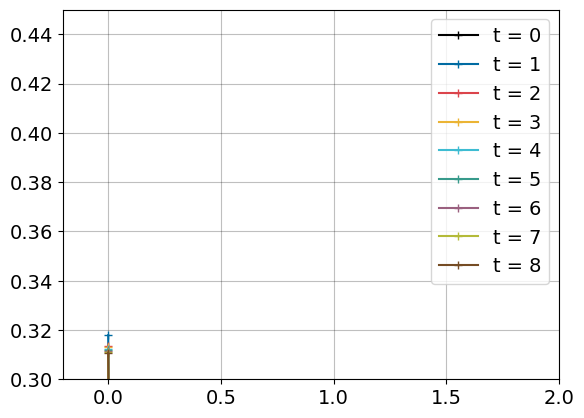

In [ ]:
for t in range(T - 291):
    plt.plot(ss.internals[hh_name]['b_bhat_grid'], b_margdist_list[t], marker = '+', label=f't = {t}')
    # plt.plot(ss.internals['hh_housecons']['b_bhat_grid'], b_margdist_neg_list[t], marker = 'x', ls = ':', label=f't = {t}')

plt.xlim(-0.2, 2)
plt.ylim(0.3, 0.45)
# plt.ylim(0.5, 0.525)
plt.legend()

## 2.1. Plotting IRFs and more

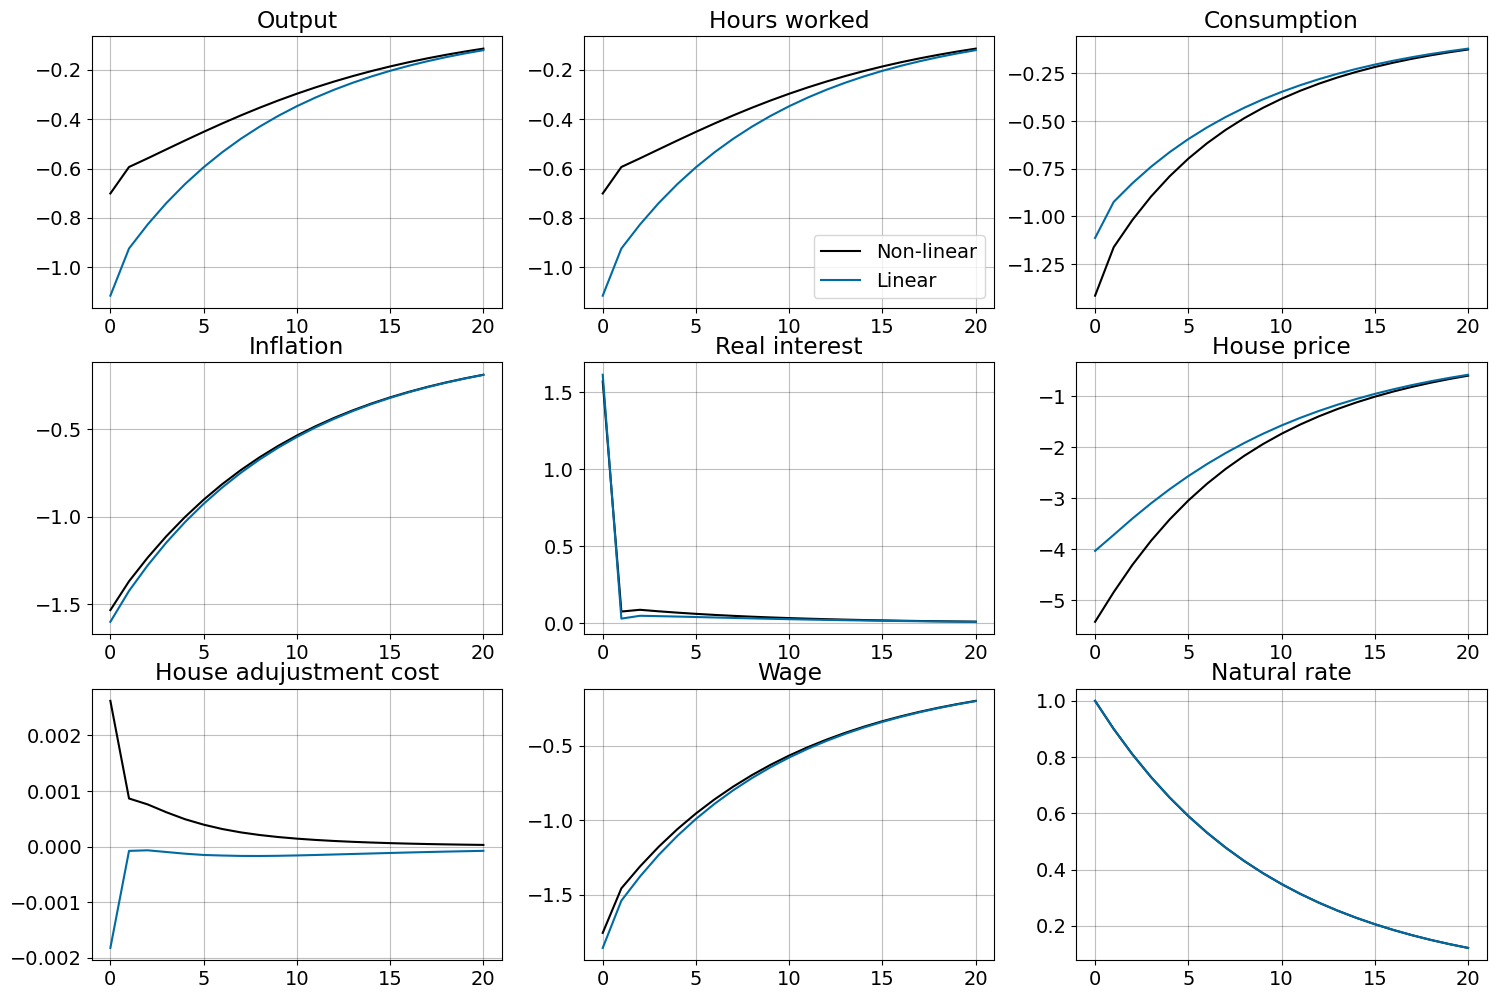

-0.6021797841268319


In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(18,12))
ax = ax.flatten()

var_name = {'Y': 'Output', 'N': 'Hours worked', 'C_BHAT': 'Consumption', 
            'pi': 'Inflation', 'r': 'Real interest', 'qh': 'House price', 'CHI': 'House adujustment cost',
            'w': 'Wage', 'rstar': 'Natural rate'}

for i, (key, value) in enumerate(var_name.items()):   
    ax[i].plot(100*ifr_main[key][:21])
    ax[i].plot(100*ifr_main_lin[key][:21])
    ax[i].set_title(var_name[key])
    if i == 1:
        ax[i].legend(['Non-linear', 'Linear'])

plt.show()
print(100*np.max(ifr_main['qh'][1:21]))

# 3. Getting hump-shaped IRFs

In [236]:
from numba import njit
@njit
def manipulate_separable(M, E):
    """ Here, E is the expectation matrix, M is the FIRE Jacobian """
    T, m = M.shape
    assert T == m
    assert E.shape == (T, T)
    
    M_beh = np.empty_like(M)
    for t in range(T):
        for s in range(T):
            summand = 0
            for tau in range(min(s,t)+1):
                if tau > 0:
                    summand += (E[tau, s] - E[tau-1, s]) * M[t - tau, s - tau]
                else:
                    summand += E[tau, s] * M[t - tau, s - tau]
            M_beh[t, s] = summand
    return M_beh

def E_sticky_exp(theta, T=T, sticky_info=False):
    col = 1 - theta**(1 + np.arange(T))
    E = np.tile(col[:, np.newaxis], (1, T))
    if sticky_info:
        return E
    else:
        E = np.triu(E, +1) + np.tril(np.ones((T, T)))
        return E

In [237]:
from sequence_jacobian import JacobianDict
import scipy

rho_r, sig_r = 0.95, 0.01
dr = sig_r * rho_r ** (np.arange(T))
xi = 0.95

input_list = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'gamma', 'gamma_p']
output_list = ['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI', 'UCE_BHAT']

Js = {'hh_housecons_sep': hh1.jacobian(ss, inputs=input_list, outputs=output_list, T=T)}
print(hh1.name) # verify that 'hh_housecons_sep' is the name of the het-agent household block

jac_ = {}
for output in output_list:
    jac_[output] = {}
    for input in input_list:
        jac_[output][input] = manipulate_separable(Js['hh_housecons_sep'][output][input], E_sticky_exp(xi))

Js_myopic = {'hh_housecons_sep': JacobianDict(jac_, inputs=input_list, outputs=output_list, name='hh1')}

combine_blocks = combine(blocks) 
Js_myopic = {'hh_housecons_sep': JacobianDict(jac_, inputs=input_list, 
                                   outputs=output_list, name='hank')}

irf_B_myopic = (combine_blocks.solve_jacobian(ss, unknowns=unknowns, targets=targets, T=T,
                                              Js=Js_myopic, inputs=['rstar'], 
                                              outputs=['Y', 'qh', 'C_BHAT', 'pi', 'r', 'i']) @ {'rstar': dr})

irf_B = (combine_blocks.solve_jacobian(ss, unknowns=unknowns, targets=targets, T=T,
                                        Js=Js, inputs=['rstar'], outputs=['Y', 'qh', 'C_BHAT', 'pi', 'r', 'i']) @ {'rstar': dr})

# irf_hump = combine_blocks.solve_impulse_linear(ss, unknowns, targets, inputs=rstar_shock, internals=[hh_name])
# ifr_hump_nonlin = hank.solve_impulse_nonlinear(ss, unknowns, targets, rstar_shock, 
#                                                internals=[hh_name], verbose = False, Js = Js_myopic)

hh_housecons_sep


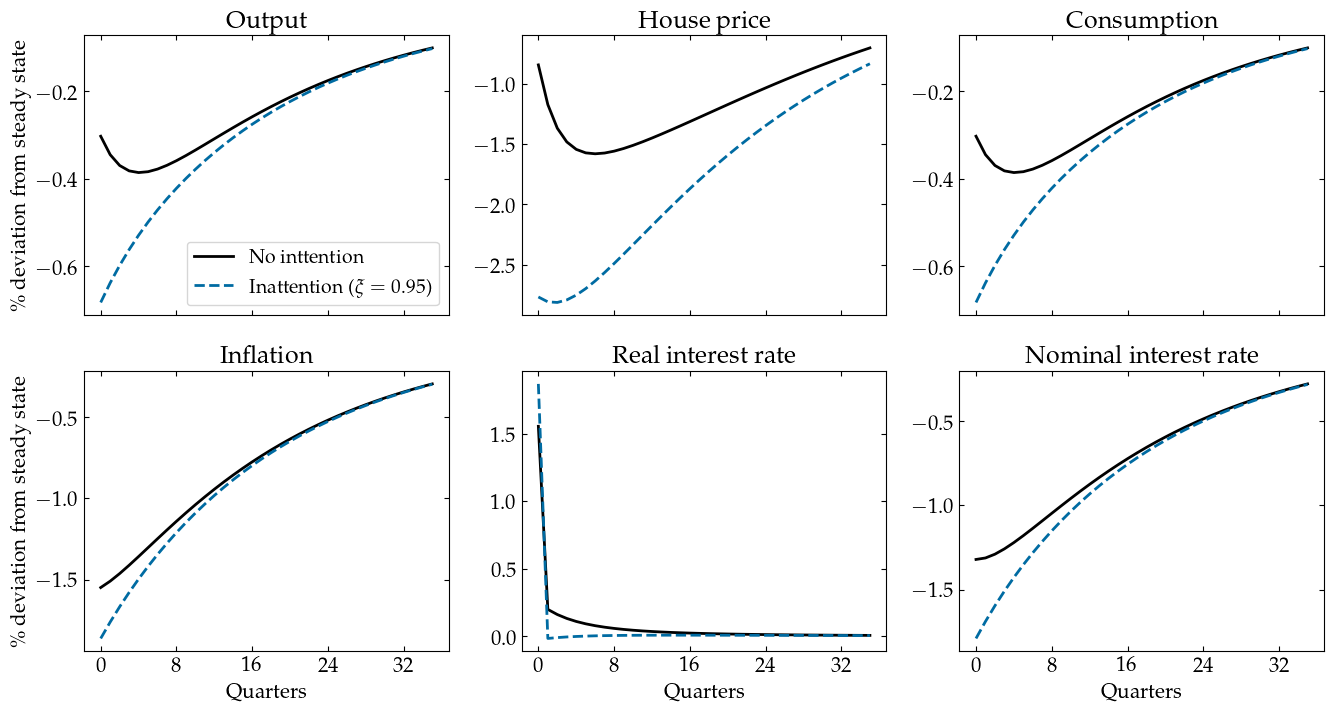

In [ ]:
import os
fig, ax = plt.subplots(2, 3, figsize=(16,8), sharex=True)
ax = ax.flatten()

var_name = {'Y': 'Output', 'qh': 'House price', 'C_BHAT': 'Consumption', 'pi': 'Inflation', 
            'r': 'Real interest rate', 'i': 'Nominal interest rate'}

H = 36
interval = 8
# for i, var in enumerate(var_plot):
for i, (key, value) in enumerate(var_name.items()):   
    ax[i].plot(100*irf_B_myopic[key][:H], linewidth=2)
    ax[i].plot(100*irf_B[key][:H], ls = '--', linewidth=2)
    # ax[i].plot(100*irf_hump[key][:H])
    ax[i].set_title(var_name[key])
    ax[i].set_xticks(range(0, H + 1, interval))
    ax[i].set_xticklabels(range(0, H + 1, interval))
    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    
    if i == 0:
        ax[i].legend(['No inttention', fr'Inattention ($\xi =$ {xi})'], fontsize=14)
        ax[i].set_ylabel('\% deviation from steady state')
    elif i == 3:
        ax[i].set_ylabel('\% deviation from steady state')

    if i == 3 or i == 4 or i == 5:
        ax[i].set_xlabel('Quarters')
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"

    # Save the plot
    fig.savefig(os.path.join(figure_path, 'Baseline mp shock.pdf'), dpi=1000, bbox_inches='tight')

In [239]:
import pandas as pd
import os

# Define the path to the Excel file
subfolder = 'Misc'
filename = 'rrshockirfs.xlsx'  # Replace with your actual file name
file_path = os.path.join(subfolder, filename)

# Load the Excel file into a DataFrame
df = pd.read_excel(file_path, sheet_name='gamma', header = None)

col_name = ['r', 'C_BHAT', 'qh', 'Y', 'pi', 'SPX', 'unemp']
df.columns = col_name

df_bands = pd.read_excel(file_path, sheet_name='gammabands', header = None)

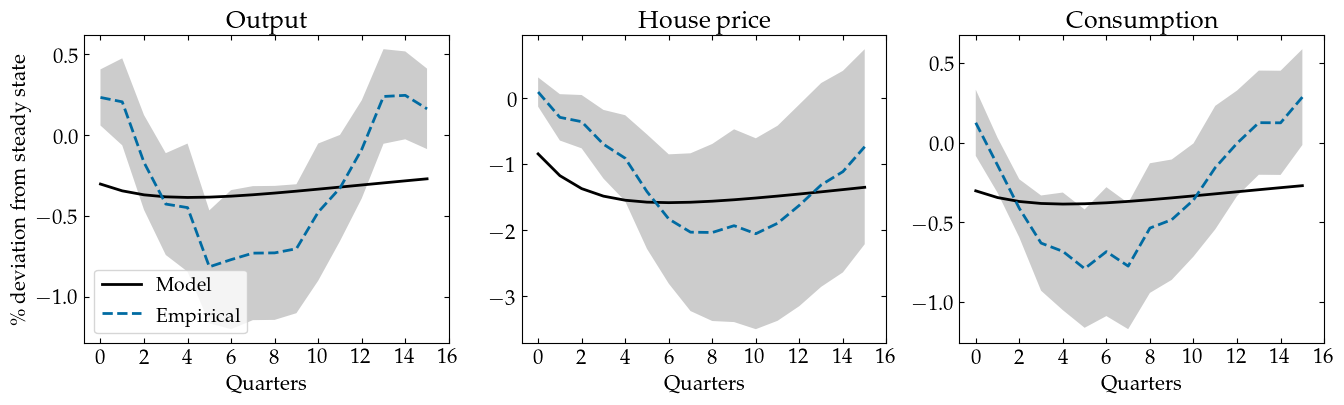

In [243]:
fig, ax = plt.subplots(1, 3, figsize=(16,4), sharex=True)
ax = ax.flatten()

var_name = {'Y': 'Output', 'qh': 'House price', 'C_BHAT': 'Consumption'}

H = 16
interval = 2
# for i, var in enumerate(var_plot):
for i, (key, value) in enumerate(var_name.items()):   
    ax[i].plot(100*irf_B_myopic[key][:H], linewidth=2)

    if key == 'qh' or key == 'C_BHAT' or key == 'Y':
        ax[i].plot(100*df[key][:H], ls = '--', linewidth=2)

    if key == 'qh':
        ax[i].fill_between(range(H), 100*df_bands[2][:H], 100*df_bands[2 + 7][:H], alpha = 0.2)

    if key == 'C_BHAT':
        ax[i].fill_between(range(H), 100*df_bands[1][:H], 100*df_bands[1 + 7][:H], alpha = 0.2)

    if key == 'Y':
        ax[i].fill_between(range(H), 100*df_bands[3][:H], 100*df_bands[3 + 7][:H], alpha = 0.2)
        
    ax[i].set_title(var_name[key])
    ax[i].set_xticks(range(0, H + 1, interval))
    ax[i].set_xticklabels(range(0, H + 1, interval))
    ax[i].tick_params(direction='in', top=True, bottom=True, left=True, right=True)
    
    if i == 0:
        ax[i].legend(['Model', r'Empirical'], fontsize=14)
        ax[i].set_ylabel('\% deviation from steady state')
    elif i == 3:
        ax[i].set_ylabel('\% deviation from steady state')

    if i == 0 or i == 1 or i == 2:
        ax[i].set_xlabel('Quarters')
plt.show()

save = False
if save:
    figure_path = "/Users/thoma/OneDrive/Skrivebord/KU/9. semester/Thesis/Code/Model/HANK/sequence-jacobian/figs"

    # Save the plot
    fig.savefig(os.path.join(figure_path, 'Empirical comparsion.pdf'), dpi=1000, bbox_inches='tight')

In [ ]:
plt.plot(Js_myopic['hh_housecons_sep']['C_BHAT']['r'][10])
plt.plot(Js['hh_housecons_sep']['C_BHAT']['r'][10])

In [ ]:
rho_r, sig_r = 0.6, 0.01/4
dr = sig_r * rho_r ** (np.arange(T))
rstar_shock = {"rstar": dr}

irf_B_myopic = (hank.solve_jacobian(ss, unknowns=unknowns, targets=targets, T=T,
                                        Js=Js_myopic, inputs=['rstar'], outputs=['Y']) @ {'rstar': dr})['Y']

irf_B = (hank.solve_jacobian(ss, unknowns=unknowns, targets=targets, T=T,
                                        Js=Js, inputs=['rstar'], outputs=['Y']) @ {'rstar': dr})['Y']

irf_myopic = (hank.solve_jacobian(ss, unknowns=unknowns, targets=targets, T=T,
                                        Js=Js_myopic, inputs=['rstar'], outputs=['Y']) @ rstar_shock)

# 4. Inertial Taylor Rule

In [101]:
# load the HA block
if seperable_pref:
    hh = hh_housing_v3.hh_housecons_sep
else:
    hh = hh_housing_v3.hh_housecons

# add hetinputs to the model
hh1 = hh.add_hetinputs([utils.make_grids, utils.income])

if seperable_pref:
    blocks_ss = [hh1, utils.firm, utils.taylor, utils.real_rate, utils.fiscal, utils.wage_res_sep, 
                utils.mkt_clearing, utils.nkpc_ss, utils.qhouse_lag, utils.gamma_prime]
hank_ss = create_model(blocks_ss, name="Housing HANK SS")

T = 300
unknowns = ['pi', 'w', 'N', 'qh']
targets = ['nkpc_res', 'asset_mkt', 'wage_res', 'house_mkt']
exogenous = ['rstar', 'Z', 'gamma']

if seperable_pref:
    blocks = [hh1, utils.firm, utils.taylor, utils.real_rate, utils.fiscal, utils.wage_res_sep, 
                utils.mkt_clearing, utils.nkpc, utils.qhouse_lag, utils.gamma_prime]
hank = create_model(blocks, name="Housing HANK")

In [ ]:
# if seperable_pref:
#     cali_main = {'gamma': 0.8, 'theta': 0.07, 'sigma': 1.0, 'alpha': 0.05, 'bmax': 45,
#                 'hmax': 5.0, 'kmax': 2.0, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3, 'G': 0.0, 'rhom': 0.9,
#                 'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2, 'bmin': 0.0,
#                 'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'nu': 1.0, 'BBAR': 0.15, 'HBAR': 1.0, 'epsm': 0.0}
#     cali_main['rstar'] = 0.025/4
#     cali_main['theta'] = 0.07
#     cali_main['gamma'] = 0.8
#     cali_main['alpha'] = 0.05

#     unknowns_ss = {'beta': 0.983, 'varphi': 0.833, 'qh': 15.112}
# ss0 = hank_ss.solve_steady_state(cali_main, unknowns_ss, targets_ss, solver="hybr")
# print(f"beta: {ss0['beta']:.3f}, varphi: {ss0['varphi']:.3f}, qh: {ss0['qh']:.3f}")

cali_main = {'gamma': 0.8, 'sigma': 1.0, 'alpha': 0.05, 'bmax': 45, 'rhom': 0.89, 'epsm': 0.0,
            'hmax': 5.0, 'kmax': 2.0, 'nB': 50, 'nH': 70, 'nK': 50, 'nZ': 3, 'G': 0.16, 'qh': 8.0,
            'rho_z': 0.966, 'sigma_z': 0.92, 'N': 1.0, 'Z': 1.0, 'pi': 0.0, 'mu': 1.2, 'bmin': 0.0,
            'kappa': 0.1, 'rstar': 0.005, 'phi': 1.5, 'nu': 2.0, 'BBAR': 0.26, 'HBAR': 1.0}
cali_main['rstar'] = 0.02/4
# cali_main['theta'] = 0.045
cali_main['gamma'] = 0.8
cali_main['alpha'] = 0.1

unknowns_ss = {'beta': 0.983, 'varphi': 0.833, 'theta': 0.04}
targets_ss = {'goods_mkt': 0, 'wage_res': 0, 'house_mkt': 0}

ss0 = hank_ss.solve_steady_state(cali_main, unknowns_ss, targets_ss, solver="hybr")
print(f"beta: {ss0['beta']:.3f}, varphi: {ss0['varphi']:.3f}, theta: {ss0['theta']:.3f}, qh: {ss0['qh']:.3f}")

cali_lowgam = cali_main.copy()
cali_lowgam['gamma'] = 0.6
ss_lowgam = hank_ss.solve_steady_state(cali_lowgam, unknowns_ss, targets_ss, solver="hybr")


beta: 0.984, varphi: 0.992, theta: 0.050, qh: 8.000


In [108]:
ss_lowgamm = hank.steady_state(ss_lowgam)
print(f"i: {ss0['i']}")
print(0.025/4)

i: 0.004999999999500649
0.00625


In [109]:
# Checking that the steady state DAG created above is valid
ss = hank.steady_state(ss0)
print(ss)

for k in ss0.keys():
    assert np.all(np.isclose(ss[k], ss0[k]))

<SteadyStateDict: ['beta', 'gamma', 'theta', 'sigma', 'qh', 'alpha', 'bmin', 'bmax', 'hmax', 'kmax', 'nB', 'nH', 'nK', 'nZ', 'rho_z', 'sigma_z', 'w', 'N', 'Z', 'pi', 'mu', 'kappa', 'rstar', 'rhom', 'phi', 'epsm', 'BBAR', 'G', 'varphi', 'nu', 'HBAR', 'gamma_p', 'qh_lag', 'i', 'i_res', 'r', 'Tax', 'Y', 'Div', 'H_BHAT', 'B_BHAT', 'C_BHAT', 'UCE_BHAT', 'CHI', 'asset_mkt', 'goods_mkt', 'house_mkt', 'wage_res', 'nkpc_res'], internals=['hh_housecons_sep']>


In [110]:
sig_r = 0.01
dr = np.zeros(T)
dr[0] = sig_r
dr_neg = -dr
rstar_shock = {"epsm": dr}

ifr_main = hank.solve_impulse_nonlinear(ss, unknowns, targets, rstar_shock, internals=[hh_name], verbose = False)
ifr_main_lowgam = hank.solve_impulse_nonlinear(ss_lowgamm, unknowns, targets, rstar_shock, internals=[hh_name], verbose = False)
# ifr_main_lin = hank.solve_impulse_linear(ss, unknowns, targets, rstar_shock, internals=[hh_name], verbose = False)

Solving taylor_inner for ['i'] to hit ['i_res']
On iteration 0
   max error for i_res is 1.00E-02
On iteration 1
   max error for i_res is 4.90E-06
On iteration 2
   max error for i_res is 7.16E-09
Solving taylor_inner for ['i'] to hit ['i_res']
On iteration 0
   max error for i_res is 5.13E-03
On iteration 1
   max error for i_res is 1.80E-05
On iteration 2
   max error for i_res is 3.69E-08
On iteration 3
   max error for i_res is 3.67E-11
Solving taylor_inner for ['i'] to hit ['i_res']
On iteration 0
   max error for i_res is 6.20E-03
On iteration 1
   max error for i_res is 1.73E-05
On iteration 2
   max error for i_res is 3.20E-08
On iteration 3
   max error for i_res is 2.73E-11
Solving taylor_inner for ['i'] to hit ['i_res']
On iteration 0
   max error for i_res is 6.38E-03
On iteration 1
   max error for i_res is 1.47E-05
On iteration 2
   max error for i_res is 2.38E-08
On iteration 3
   max error for i_res is 2.22E-11
Solving taylor_inner for ['i'] to hit ['i_res']
On iterati

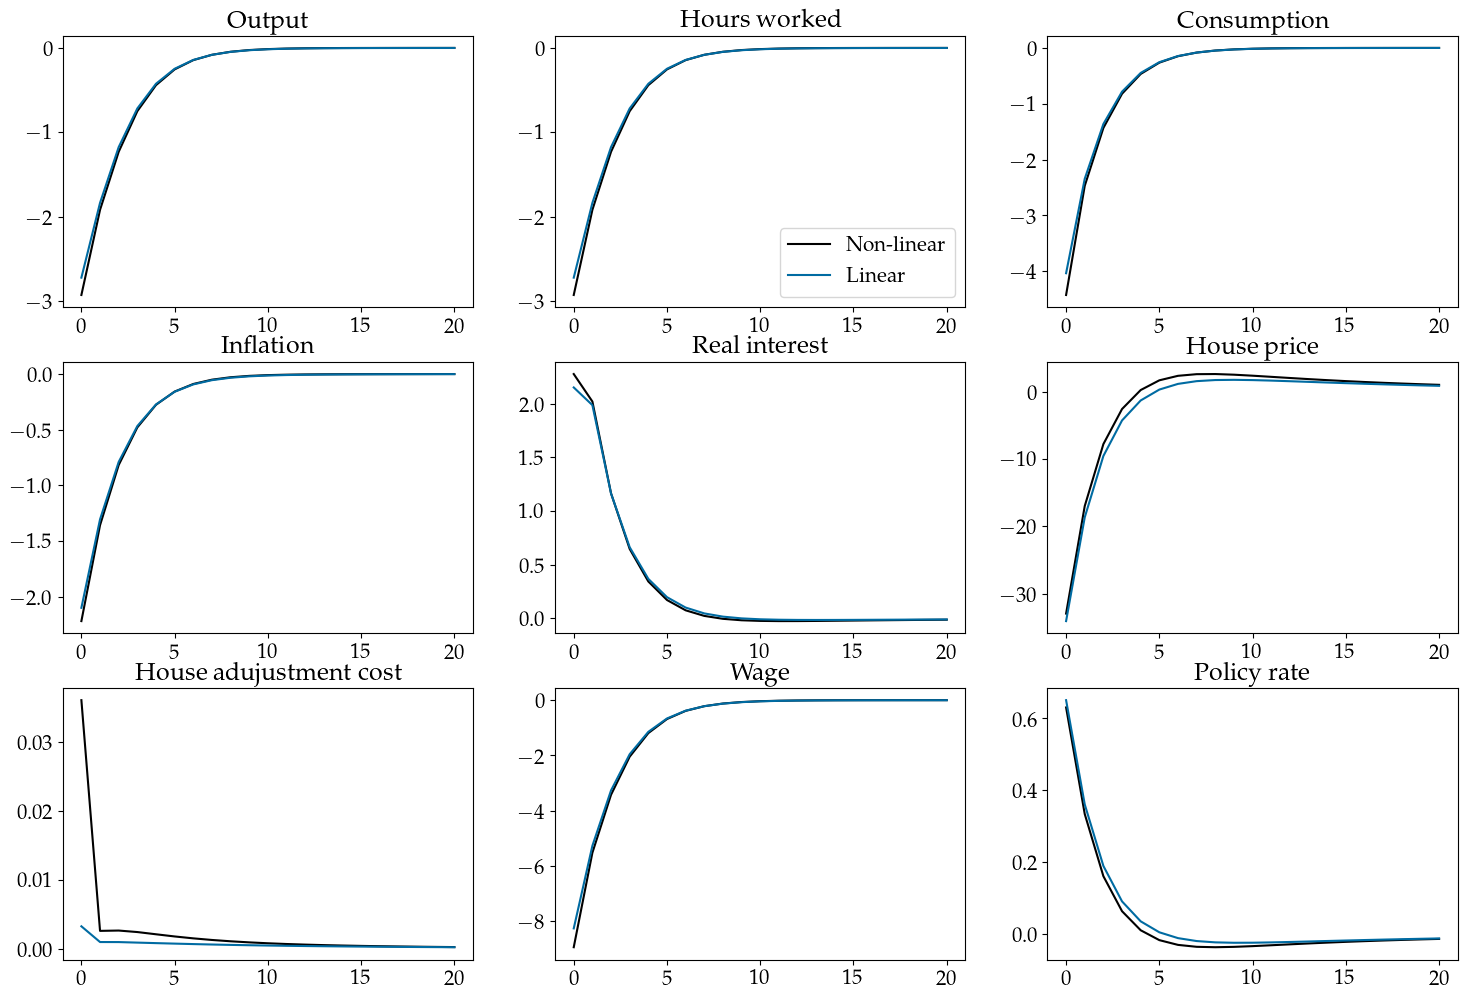

2.592348489948413


In [111]:
fig, ax = plt.subplots(3, 3, figsize=(18,12))
ax = ax.flatten()

var_name = {'Y': 'Output', 'N': 'Hours worked', 'C_BHAT': 'Consumption', 
            'pi': 'Inflation', 'r': 'Real interest', 'qh': 'House price', 'CHI': 'House adujustment cost',
            'w': 'Wage', 'i': 'Policy rate'}

for i, (key, value) in enumerate(var_name.items()):   
    ax[i].plot(100*ifr_main[key][:21])
    ax[i].plot(100*ifr_main_lowgam[key][:21])
    # ax[i].plot(100*ifr_main_lin[key][:21])
    ax[i].set_title(var_name[key])
    if i == 1:
        ax[i].legend(['Non-linear', 'Linear'])

plt.show()
print(100*np.max(ifr_main['qh'][1:21]))

In [104]:
from numba import njit
@njit
def manipulate_separable(M, E):
    """ Here, E is the expectation matrix, M is the FIRE Jacobian """
    T, m = M.shape
    assert T == m
    assert E.shape == (T, T)
    
    M_beh = np.empty_like(M)
    for t in range(T):
        for s in range(T):
            summand = 0
            for tau in range(min(s,t)+1):
                if tau > 0:
                    summand += (E[tau, s] - E[tau-1, s]) * M[t - tau, s - tau]
                else:
                    summand += E[tau, s] * M[t - tau, s - tau]
            M_beh[t, s] = summand
    return M_beh

def E_sticky_exp(theta, T=T, sticky_info=False):
    col = 1 - theta**(1 + np.arange(T))
    E = np.tile(col[:, np.newaxis], (1, T))
    if sticky_info:
        return E
    else:
        E = np.triu(E, +1) + np.tril(np.ones((T, T)))
        return E

In [105]:
from sequence_jacobian import JacobianDict
import scipy

sig_r = 0.01
dr = np.zeros(T)
dr[0] = sig_r

input_list = ['qh', 'r', 'qh_lag', 'Tax', 'Div', 'N', 'w', 'gamma', 'gamma_p']
output_list = ['C_BHAT', 'H_BHAT', 'B_BHAT', 'CHI', 'UCE_BHAT']

Js = {'hh_housecons_sep': hh1.jacobian(ss, inputs=input_list, outputs=output_list, T=T)}
print(hh1.name) # verify that 'hh_housecons_sep' is the name of the het-agent household block

jac_ = {}
for output in output_list:
    jac_[output] = {}
    for input in input_list:
        jac_[output][input] = manipulate_separable(Js['hh_housecons_sep'][output][input], E_sticky_exp(0.99))

Js_myopic = {'hh_housecons_sep': JacobianDict(jac_, inputs=input_list, outputs=output_list, name='hh1')}

combine_blocks = combine(blocks) 
Js_myopic = {'hh_housecons_sep': JacobianDict(jac_, inputs=input_list, 
                                   outputs=output_list, name='hank')}

irf_B_myopic = (combine_blocks.solve_jacobian(ss, unknowns=unknowns, targets=targets, T=T,
                                        Js=Js_myopic, inputs=['epsm'], outputs=['Y', 'qh', 'C_BHAT', 'pi', 'r', 'i']) @ {'epsm': dr})

irf_B = (combine_blocks.solve_jacobian(ss, unknowns=unknowns, targets=targets, T=T,
                                        Js=Js, inputs=['epsm'], outputs=['Y', 'qh', 'C_BHAT', 'pi', 'r', 'i']) @ {'epsm': dr})

hh_housecons_sep


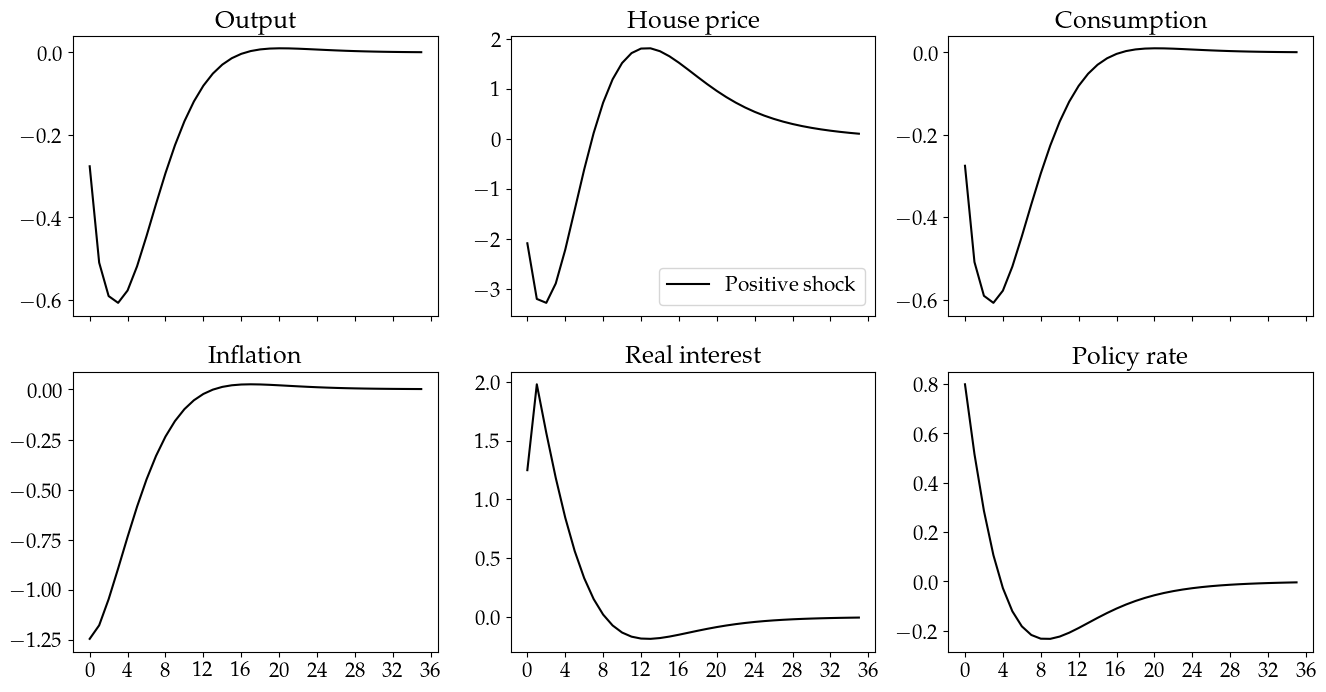

In [106]:
fig, ax = plt.subplots(2, 3, figsize=(16,8), sharex=True)
ax = ax.flatten()

var_name = {'Y': 'Output', 'qh': 'House price', 'C_BHAT': 'Consumption', 
            'pi': 'Inflation', 'r': 'Real interest', 'i': 'Policy rate'}

H = 36
interval = 4
# for i, var in enumerate(var_plot):
for i, (key, value) in enumerate(var_name.items()):   
    ax[i].plot(100*irf_B_myopic[key][:H])
    # ax[i].plot(100*irf_B[key][:H])
    # ax[i].plot(100*irf_hump[key][:H])
    ax[i].set_title(var_name[key])
    ax[i].set_xticks(range(0, H + 1, interval))
    ax[i].set_xticklabels(range(0, H + 1, interval))
    
    if i == 1:
        ax[i].legend(['Positive shock', 'Negative shock'])
        
plt.show()